In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, Dropout, Dense, LSTM, GRU, Input, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import os
from tqdm.notebook import tqdm_notebook
import spacy
from wordcloud import WordCloud
import joblib
import tensorflow_hub as hub
from warnings import filterwarnings
from cleantext import clean

In [2]:
filterwarnings('ignore')

In [3]:
nlp = spacy.load('en_core_web_sm')

## Import dataset

In [4]:
data = pd.read_csv('./Emotion_classify_Data.csv')
data.head()

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear


## Data Preprocessing and EDA

In [5]:
data.isnull().sum()

Comment    0
Emotion    0
dtype: int64

In [6]:
data.duplicated().sum()

0

In [7]:
emotion_count = data['Emotion'].value_counts(sort = False).reset_index()
emotion_count

,Emotion,count
0,fear,1937
1,anger,2000
2,joy,2000


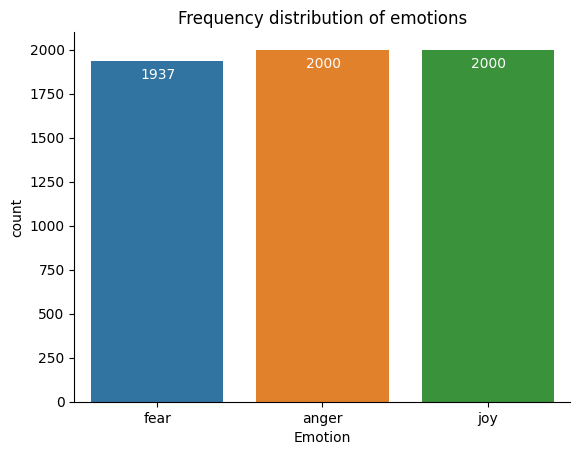

In [8]:
sns.barplot(x = emotion_count['Emotion'], y = emotion_count['count'])
sns.despine()
for i, emotion, count in emotion_count.itertuples():
    plt.text(i-0.1, count-100, s = count, color = 'white')
plt.title("Frequency distribution of emotions");

- Cleaning text consist of various processes, like, converting them to lower case, removing punctuations and so on.
- `clean_texts` is a function to preprocess the texts

In [9]:
def clean_texts():
    corpus = []
    for text in tqdm_notebook(data['Comment']):
        text = clean(text, no_urls = True, no_emails = True, no_numbers = True, 
                     no_currency_symbols = True, no_punct = True, no_emoji = True, 
                     replace_with_url = '', replace_with_number = '', replace_with_currency_symbol = '', 
                     replace_with_email = '', no_line_breaks = True)
        doc = nlp(text)
        text = [token.lemma_ for token in doc 
                if not token.is_stop and len(token.text)>1 and token.lemma_ not in ['feel', 'feeling', 've']]
        text = " ".join(text)
        corpus.append(text)
    
    return corpus

In [10]:
corpus = clean_texts()

  0%|          | 0/5937 [00:00<?, ?it/s]

In [11]:
data['cleaned_text'] = pd.Series(corpus)

In [12]:
data['cleaned_text']

0             seriously hate subject death reluctant drop
1                                           life appalled
2       sit write start dig think afraid accept possib...
3                            angry like idiot trust place
4                  suspicious outside like rapture happen
                              ...                        
5932                                     begin distressed
5933      leave annoyed angry thinking center stupid joke
5934    marry ready offer get club perfect good look g...
5935    reluctant apply want able find company know pe...
5936                  want apologize like heartless bitch
Name: cleaned_text, Length: 5937, dtype: object

- Label encoding the `Emotion` column

In [13]:
data.drop(columns = ['Comment'], inplace = True)
data['Emotion'] = data['Emotion'].map({
    'anger':0,
    'fear':1,
    'joy':2
})

In [14]:
data.head()

,Emotion,cleaned_text
0,1,seriously hate subject death reluctant drop
1,0,life appalled
2,1,sit write start dig think afraid accept possib...
3,2,angry like idiot trust place
4,1,suspicious outside like rapture happen


- Removing all the texts which has 0 or 1 length

In [15]:
def remove_redundant_texts(text):
    text = text.strip()
    if len(text.split()) >= 2:
        return True
    else:
        return False

In [16]:
data = data[data['cleaned_text'].apply(remove_redundant_texts)]

In [17]:
data = data.drop_duplicates(keep = 'first')

In [18]:
data.shape

(5684, 2)

- Generating word_clouds to visualize the common words

In [19]:
words = " ".join(data['cleaned_text'].values)

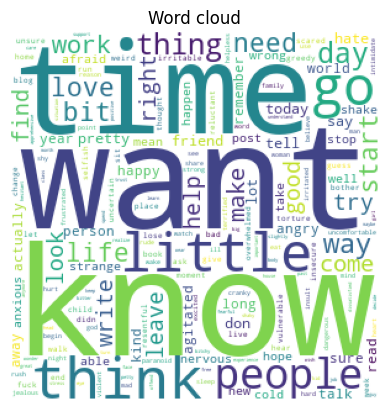

In [47]:
word_cloud = WordCloud(width = 300, height = 300, background_color = 'white').generate(words)
plt.imshow(word_cloud)
plt.axis('off');
plt.title("Word cloud");

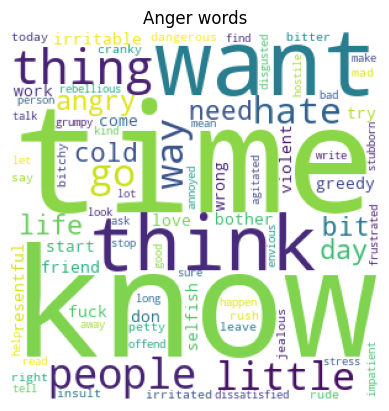

In [48]:
anger_data = data[data['Emotion'] == 0]
anger_words = " ".join(anger_data['cleaned_text'].values)
anger_word_cloud = WordCloud(width = 300, height = 300, background_color = 'white', min_font_size = 7).generate(anger_words)
plt.imshow(anger_word_cloud)
plt.axis('off');
plt.title("Anger words");

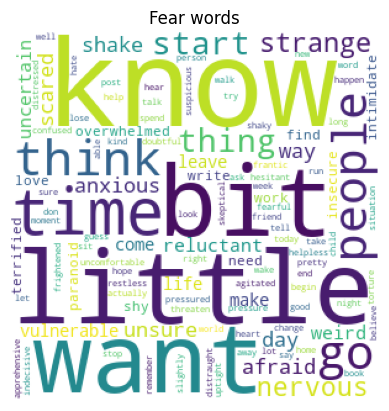

In [49]:
fear_data = data[data['Emotion'] == 1]
fear_words = " ".join(fear_data['cleaned_text'].values)
fear_word_cloud = WordCloud(width = 300, height = 300, background_color = 'white', min_font_size = 7).generate(fear_words)
plt.imshow(fear_word_cloud)
plt.axis('off');
plt.title("Fear words");

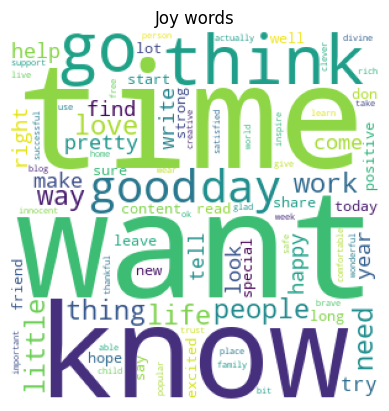

In [50]:
joy_data = data[data['Emotion'] == 2]
joy_words = " ".join(joy_data['cleaned_text'].values)
joy_word_cloud = WordCloud(width = 300, height = 300, background_color = 'white', min_font_size = 7).generate(joy_words)
plt.imshow(joy_word_cloud)
plt.axis('off');
plt.title("Joy words");

## Machine Learning modelling experiments

In [29]:
def model_performance(y_test, y_pred):
    return {
        'accuracy': np.round(accuracy_score(y_test, y_pred), 3),
        'recall': np.round(recall_score(y_test, y_pred, average = 'macro'), 3),
        'precision': np.round(precision_score(y_test, y_pred, average = 'macro'), 3),
        'f1_score': np.round(f1_score(y_test, y_pred, average = 'macro'), 3),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

- TfIdfVectorization (representing words by some weights based on their frequencies)

In [44]:
X = data['cleaned_text'].to_numpy()
y = data['Emotion'].to_numpy()
X.shape, y.shape

((5684,), (5684,))

In [45]:
tfidf = TfidfVectorizer(min_df = 3, max_df = 0.6)
X_tf_idf = tfidf.fit_transform(X)
X_tf_idf

<5684x2111 sparse matrix of type '<class 'numpy.float64'>'
	with 33867 stored elements in Compressed Sparse Row format>

In [46]:
joblib.dump(tfidf, 'tfidf_vect.pkl')

['tfidf_vect.pkl']

In [47]:
most_imp_10_words = np.argsort(tfidf.idf_)[:10]
tfidf.get_feature_names_out()[most_imp_10_words]

array(['like', 'not', 'know', 'time', 'want', 'little', 'think', 'go',
       'people', 'thing'], dtype=object)

### Train-test split

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_tf_idf, y, test_size = 0.25, random_state = 1)

In [25]:
X_train.shape, y_train.shape

((4263, 2111), (4263,))

## Random Forest

In [57]:
rdf = RandomForestClassifier()
rdf.fit(X_train, y_train)
y_pred_rdf = rdf.predict(X_test)

rdf_performance = model_performance(y_test, y_pred_rdf)
rdf_performance

{'accuracy': 0.93,
 'recall': 0.931,
 'precision': 0.931,
 'f1_score': 0.931,
 'confusion_matrix': array([[447,  18,  32],
        [ 10, 420,  14],
        [ 13,  12, 455]], dtype=int64)}

## Gradient Boosting Classifier

In [58]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)

gbc_performance = model_performance(y_test, y_pred_gbc)
gbc_performance

{'accuracy': 0.869,
 'recall': 0.869,
 'precision': 0.886,
 'f1_score': 0.871,
 'confusion_matrix': array([[403,   7,  87],
        [ 24, 368,  52],
        [  8,   8, 464]], dtype=int64)}

## XGBoost

In [63]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

xgb_performance = model_performance(y_test, y_pred_xgb)
xgb_performance

{'accuracy': 0.919,
 'recall': 0.92,
 'precision': 0.922,
 'f1_score': 0.92,
 'confusion_matrix': array([[437,  13,  47],
        [ 13, 410,  21],
        [ 10,  11, 459]], dtype=int64)}

## Light GBM

In [64]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)

lgbm_performance = model_performance(y_test, y_pred_lgbm)
lgbm_performance

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5361
[LightGBM] [Info] Number of data points in the train set: 4263, number of used features: 301
[LightGBM] [Info] Start training from score -1.114215
[LightGBM] [Info] Start training from score -1.096503
[LightGBM] [Info] Start training from score -1.085330


{'accuracy': 0.824,
 'recall': 0.824,
 'precision': 0.838,
 'f1_score': 0.825,
 'confusion_matrix': array([[389,  18,  90],
        [ 24, 350,  70],
        [ 24,  24, 432]], dtype=int64)}

## SVM

In [65]:
svc = SVC(C = 1.5)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

svc_performance = model_performance(y_test, y_pred_svc)
svc_performance

{'accuracy': 0.925,
 'recall': 0.924,
 'precision': 0.925,
 'f1_score': 0.924,
 'confusion_matrix': array([[456,  20,  21],
        [ 14, 405,  25],
        [ 14,  13, 453]], dtype=int64)}

## CatBoost

In [66]:
ctb = CatBoostClassifier(silent = True)
ctb.fit(X_train, y_train)
y_pred_ctb = ctb.predict(X_test)

ctb_performance = model_performance(y_test, y_pred_ctb)
ctb_performance

{'accuracy': 0.936,
 'recall': 0.937,
 'precision': 0.937,
 'f1_score': 0.936,
 'confusion_matrix': array([[450,  18,  29],
        [  7, 422,  15],
        [ 12,  10, 458]], dtype=int64)}

- Summary of the machine learning models

In [70]:
model_results = pd.DataFrame(
    data = {
        'random_forest': list(rdf_performance.values())[:4],
        'gradient_boost': list(gbc_performance.values())[:4],
        'xgboost': list(xgb_performance.values())[:4],
        'svc': list(svc_performance.values())[:4],
        'lgbm': list(lgbm_performance.values())[:4],
        'catboost': list(ctb_performance.values())[:4]
    },
    index = ['accuracy', 'recall', 'precision', 'f1_score']
)

In [71]:
model_results = model_results.T

In [72]:
model_results.sort_values(by = 'f1_score', ascending = False).style.background_gradient()

,accuracy,recall,precision,f1_score
catboost,0.936000,0.937000,0.937000,0.936000
random_forest,0.930000,0.931000,0.931000,0.931000
svc,0.925000,0.924000,0.925000,0.924000
xgboost,0.919000,0.920000,0.922000,0.920000
gradient_boost,0.869000,0.869000,0.886000,0.871000
lgbm,0.824000,0.824000,0.838000,0.825000


- Saving the best model yet

In [73]:
joblib.dump(ctb, 'catboost_model.pkl')
os.listdir()

['catboost_info',
 'catboost_model.pkl',
 'Emotion_classify_Data.csv',
 'lstm_gru.zip',
 'text-emotion-nlp.ipynb']

## Deep Learning modelling experiments

- Finding the optimal text length for the dataset

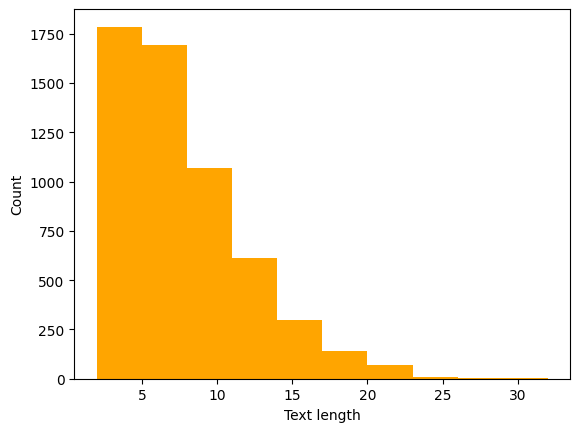

In [41]:
str_lens = [len(text.split()) for text in X]
plt.hist(x = str_lens, color = 'orange');
plt.xlabel("Text length")
plt.ylabel("Count");

- It is to be noted that, most of the texts having length  within **25**

In [32]:
X_train_deep, X_test_deep, y_train_deep, y_test_deep = train_test_split(X, y, test_size = 0.2, random_state = 1)

- Creating the text vectorization layer, to convert tokens into numbers and pad them to max_sequence_length (25)

In [33]:
text_vect = TextVectorization(max_tokens = 5000, output_sequence_length = 25, output_mode = 'int')
text_vect.adapt(X_train_deep)

In [44]:
text_vect.vocabulary_size()

5000

- Creating the embedding layer to get word embeddings of the words within the dataset, this embedding are learnt through epochs, the main goal of this layer is to learn the learn the relationship between various words

In [45]:
embedding = Embedding(input_dim = text_vect.vocabulary_size() + 1,
                      output_dim = 128,
                      input_length = 25,
                      mask_zero=True)

- Setting up the ModelCheckpoint callback to save the best model

In [46]:
def model_ckpt(model_name):
    return ModelCheckpoint(
        filepath=f'./{model_name}',
        verbose=1,
        save_best_only=True,
        monitor = 'val_accuracy'
    )

## LSTM + GRU 

In [51]:
model1 = Sequential()
model1.add(Input(shape = (1,), dtype = tf.string))
model1.add(text_vect)
model1.add(embedding)
model1.add(GRU(units=64, dropout = 0.5, return_sequences = True, recurrent_dropout=0.5))
model1.add(LSTM(units = 128, dropout=0.5, recurrent_dropout=0.5))
model1.add(BatchNormalization())
model1.add(Dropout(rate = 0.5))
model1.add(Dense(units = 3, activation = 'softmax'))

In [52]:
model1.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [53]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 25)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 25, 128)           640128    
                                                                 
 gru_1 (GRU)                 (None, 25, 64)            37248     
                                                                 
 lstm_1 (LSTM)               (None, 128)               98816     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 128)              

In [54]:
model1_hist = model1.fit(x = X_train_deep, y = y_train_deep, validation_data = (X_test_deep, y_test_deep), batch_size = 32, epochs = 5, callbacks=model_ckpt('lstm_gru'))

Epoch 1/5
143/143 [==============================] - ETA: 0s - loss: 0.2729 - accuracy: 0.8951
Epoch 1: val_accuracy improved from -inf to 0.88830, saving model to ./lstm_gru
143/143 [==============================] - 43s 253ms/step - loss: 0.2729 - accuracy: 0.8951 - val_loss: 0.7687 - val_accuracy: 0.8883
Epoch 2/5
143/143 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9565
Epoch 2: val_accuracy improved from 0.88830 to 0.90150, saving model to ./lstm_gru
143/143 [==============================] - 30s 207ms/step - loss: 0.1282 - accuracy: 0.9565 - val_loss: 0.4818 - val_accuracy: 0.9015
Epoch 3/5
143/143 [==============================] - ETA: 0s - loss: 0.1118 - accuracy: 0.9637
Epoch 3: val_accuracy improved from 0.90150 to 0.90501, saving model to ./lstm_gru
143/143 [==============================] - 29s 201ms/step - loss: 0.1118 - accuracy: 0.9637 - val_loss: 0.2708 - val_accuracy: 0.9050
Epoch 4/5
143/143 [==============================] - ETA: 0s - loss

- Function to visualize the model performance through epochs

In [49]:
def plot_model_performance(history):
    plt.figure(figsize = (10, 3))
    plt.subplot(1, 2, 1)
    sns.lineplot(x = history.epoch, y = history.history['loss'], label = 'train_loss')
    sns.lineplot(x = history.epoch, y = history.history['val_loss'], label = 'val_loss')
    plt.subplot(1, 2, 2)
    sns.lineplot(x = history.epoch, y = history.history['accuracy'], label = 'train_accuracy')
    sns.lineplot(x = history.epoch, y = history.history['val_accuracy'], label = 'val_accuracy')
    

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

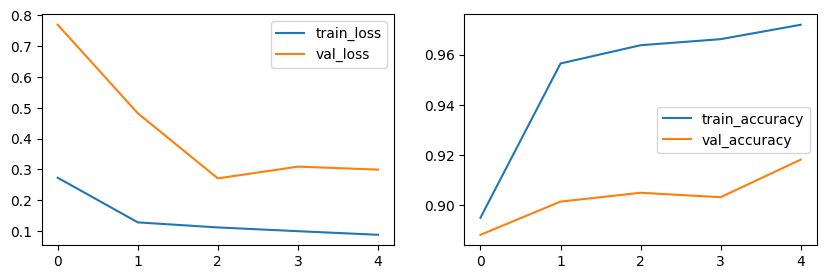

In [63]:
plot_model_performance(model1_hist)

In [41]:
deep_model = tf.keras.models.load_model("./lstm_gru")
y_deep_pred = np.argmax(deep_model.predict(X_test_deep), axis = 1)
model_performance(y_test, y_deep_pred)

36/36 [==============================] - 1s 6ms/step


{'accuracy': 0.918,
 'recall': 0.919,
 'precision': 0.918,
 'f1_score': 0.918,
 'confusion_matrix': array([[358,  22,  17],
        [ 13, 335,   8],
        [ 14,  19, 351]], dtype=int64)}

In [ ]:
# !zip -r file.zip /kaggle/working/lstm_gru

  adding: kaggle/working/lstm_gru/ (stored 0%)
  adding: kaggle/working/lstm_gru/keras_metadata.pb (deflated 89%)
  adding: kaggle/working/lstm_gru/assets/ (stored 0%)
  adding: kaggle/working/lstm_gru/variables/ (stored 0%)
  adding: kaggle/working/lstm_gru/variables/variables.data-00000-of-00001

## Universal Sentence Encoder

In [30]:
embed = hub.KerasLayer("https://kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2")

Attaching model 'google/universal-sentence-encoder/tensorflow2/universal-sentence-encoder/2' to your Kaggle notebook...


In [23]:
X = data['cleaned_text'].to_numpy()
y = data['Emotion'].to_numpy()

In [24]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [25]:
train_data = tf.data.Dataset.from_tensor_slices((X_train_new, y_train_new)).batch(batch_size = 32).prefetch(tf.data.AUTOTUNE)
test_data = tf.data.Dataset.from_tensor_slices((X_test_new, y_test_new)).batch(batch_size = 32).prefetch(tf.data.AUTOTUNE)

train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [42]:
model2 = Sequential()
model2.add(Input(shape = (), dtype = tf.string))
model2.add(embed)
model2.add(Dense(units = 128, activation = 'linear'))
model2.add(Dropout(rate = 0.5))
model2.add(Dense(units = 256, activation = 'linear'))
model2.add(Dropout(rate = 0.5))
model2.add(Dense(units = 128, activation = 'relu'))
model2.add(Dense(units = 3, activation = 'softmax'))

In [45]:
model2.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [46]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense_12 (Dense)            (None, 128)               65664     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 256)               33024     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 128)               32896     
                                                                 
 dense_15 (Dense)            (None, 3)                

In [47]:
model2_hist = model2.fit(train_data, validation_data=test_data, epochs=20)

Epoch 1/20
143/143 [==============================] - 4s 14ms/step - loss: 0.7273 - accuracy: 0.6897 - val_loss: 0.6024 - val_accuracy: 0.7520
Epoch 2/20
143/143 [==============================] - 2s 11ms/step - loss: 0.5548 - accuracy: 0.7781 - val_loss: 0.5864 - val_accuracy: 0.7643
Epoch 3/20
143/143 [==============================] - 2s 11ms/step - loss: 0.5244 - accuracy: 0.7904 - val_loss: 0.5835 - val_accuracy: 0.7669
Epoch 4/20
143/143 [==============================] - 2s 12ms/step - loss: 0.5052 - accuracy: 0.7979 - val_loss: 0.5827 - val_accuracy: 0.7634
Epoch 5/20
143/143 [==============================] - 2s 12ms/step - loss: 0.4896 - accuracy: 0.8012 - val_loss: 0.5791 - val_accuracy: 0.7696
Epoch 6/20
143/143 [==============================] - 2s 12ms/step - loss: 0.4866 - accuracy: 0.7999 - val_loss: 0.5816 - val_accuracy: 0.7784
Epoch 7/20
143/143 [==============================] - 1s 10ms/step - loss: 0.4709 - accuracy: 0.8058 - val_loss: 0.5796 - val_accuracy: 0.7740

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

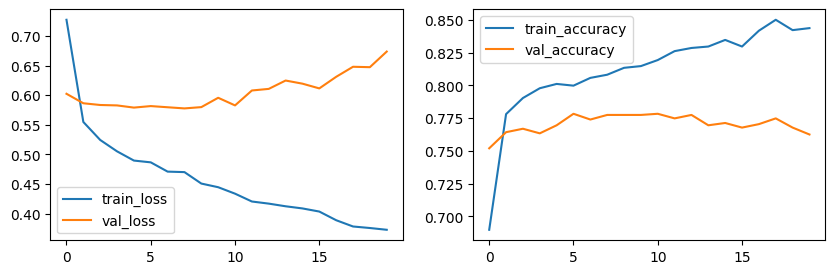

In [50]:
plot_model_performance(model2_hist)

## Best model is `CatBoost`

### Performance evaluation of `CatBoost`

In [27]:
catboost_model = joblib.load('./catboost_model.pkl')
y_pred = catboost_model.predict(X_test)   

In [49]:
performance = model_performance(y_test, y_pred)

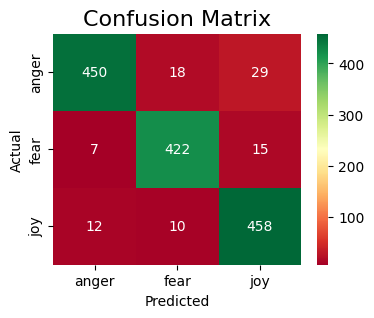

In [57]:
plt.figure(figsize = (4, 3))
sns.heatmap(performance['confusion_matrix'], annot=True, fmt = 'd', cmap = 'RdYlGn');
plt.xticks((0.5, 1.5, 2.5), ('anger', 'fear', 'joy'))
plt.yticks((0.5, 1.5, 2.5), ('anger', 'fear', 'joy'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix", fontsize = 16);